**1. Instalación y Carga de Librerías**

In [ ]:
# Instalar paquetes necesarios (si no están ya instalados)
!pip install spacy

# Descargar modelo de SpaCy en inglés (si no está disponible)
!python -m spacy download en_core_web_sm

# Importar librerías necesarias
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# **Entrenamiento y Testeo de un Modelo de Análisis de Sentimiento**

**1. Preparar los datos**

Cargar y dividir los datos: Vamos a dividir los datos preprocesados en entrenamiento (train) y test, asegurando que la proporción de clases se mantenga estable (estratificación).

In [ ]:
# Cargar el dataset preprocesado de la Etapa 2
df = pd.read_csv("preprocessed_reviews2.csv")

# Verificar que los datos se cargaron correctamente
print("Dataset cargado correctamente:")
print(df.info())

# Eliminar valores nulos en 'clean_review'
df = df.dropna(subset=['clean_review'])

# Definir variables de entrada (X) y salida (y)
X = df['clean_review']  # Texto limpio como entrada
y = (df['overall'] >= 4).astype(int)  # 1 = positivo, 0 = negativo

# Dividir en conjunto de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Dataset cargado correctamente:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9995 entries, 0 to 9994
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   reviewText    9995 non-null   object 
 1   overall       9995 non-null   float64
 2   clean_review  9991 non-null   object 
dtypes: float64(1), object(2)
memory usage: 234.4+ KB
None


**2. Codificación de textos con TF-IDF (Bag-of-Words)**

En esta sección, convierte el texto preprocesado en una representación numérica utilizando TF-IDF

Justificación de los parámetros del vectorizador

max_features=5000 → Limitar el vocabulario a las 5000 palabras más frecuentes para reducir la dimensionalidad y mejorar la eficiencia.

ngram_range=(1,2) → Incluir unigramas y bigramas para capturar mejor el contexto de las palabras.

stop_words='english' → Eliminar palabras irrelevantes para reducir ruido en el modelo.

In [ ]:
# Vectorización con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Guardar el vectorizador para uso futuro
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print(f"Dimensión de la matriz TF-IDF: {X_train_tfidf.shape}")

Dimensión de la matriz TF-IDF: (7992, 5000)


**3. Entrenamiento de Modelos**

Elegimos dos modelos diferentes:
1. Regresión Logística

2. Random Forest

In [ ]:
# Modelo 1: Regresión Logística
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_tfidf, y_train)

# Modelo 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Guardar los modelos entrenados
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(log_model, f)

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Modelos entrenados y guardados: 'logistic_model.pkl' y 'random_forest_model.pkl'")

Modelos entrenados y guardados: 'logistic_model.pkl' y 'random_forest_model.pkl'


**4. Evaluación y comparación de los modelos**

Ahora probamos los modelos en el conjunto de test.

Evaluación de Regresión Logística:

              precision    recall  f1-score   support

           0       0.91      0.15      0.25       278
           1       0.88      1.00      0.93      1721

    accuracy                           0.88      1999
   macro avg       0.89      0.57      0.59      1999
weighted avg       0.88      0.88      0.84      1999

Evaluación de Random Forest:

              precision    recall  f1-score   support

           0       0.71      0.13      0.22       278
           1       0.88      0.99      0.93      1721

    accuracy                           0.87      1999
   macro avg       0.79      0.56      0.57      1999
weighted avg       0.85      0.87      0.83      1999



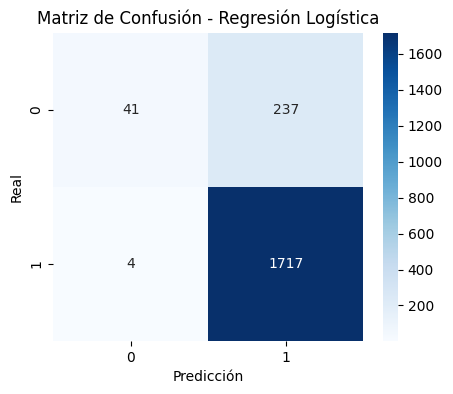

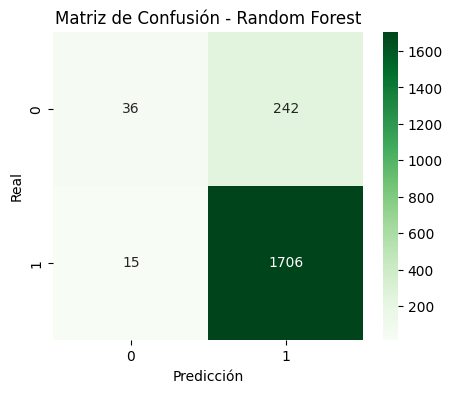

Precisión de Regresión Logística: 0.8794
Precisión de Random Forest: 0.8714


In [ ]:
# Predicciones
y_pred_log = log_model.predict(X_test_tfidf)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluación de Regresión Logística
print("Evaluación de Regresión Logística:\n")
print(classification_report(y_test, y_pred_log))

# Evaluación de Random Forest
print("Evaluación de Random Forest:\n")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión para Regresión Logística
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Matriz de Confusión para Random Forest
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Comparación de Precisión
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Precisión de Regresión Logística: {accuracy_log:.4f}")
print(f"Precisión de Random Forest: {accuracy_rf:.4f}")



Comparación de Modelos: Regresión Logística vs Random Forest
Ambos modelos fueron evaluados en términos de precisión, recall y F1-score, con resultados distintos para las clases positiva (1) y negativa (0).

**Regresión Logística**
Precisión global (Accuracy): 88%
F1-score general: 0.88

Clase 1 (Reseñas Positivas)

Precision: 0.88 De todas las reseñas que predijo como positivas, el 88% lo eran realmente.

Recall: 1.00 Capturó el 100% de las reseñas positivas.

F1-score: 0.93 Buen equilibrio entre precisión y recall.

Clase 0 (Reseñas Negativas)

Precision: 0.91 El 91% de las predicciones negativas fueron correctas.

Recall: 0.15 Solo detectó correctamente el 15% de las reseñas negativas, ignorando muchas.

Conclusión: El modelo tiene un sesgo claro hacia la clase positiva (1), detectándola con mucha precisión pero fallando en capturar las reseñas negativas (0). Esto sugiere un problema de desbalanceo de clases, donde el modelo está optimizado para las reseñas positivas.

**Random Forest**
Precisión global (Accuracy): 87%
F1-score general: 0.83

Clase 1 (Reseñas Positivas)

Precision: 0.88 Igual que la regresión logística.
Recall: 0.99 Casi todas las reseñas positivas fueron detectadas correctamente.
F1-score: 0.93 Muy similar al modelo de regresión logística.
Clase 0 (Reseñas Negativas)

Precision: 0.71 Peor que la regresión logística, ya que más reseñas falsamente negativas fueron clasificadas erróneamente.
Recall: 0.13 Muy bajo, solo detectó correctamente el 13% de las reseñas negativas.

Conclusión: Random Forest no mejora la detección de reseñas negativas, y sufre el mismo problema de sesgo hacia las reseñas positivas. Sin embargo, su precisión general es similar a la regresión logística.

Conclusión General: Ambos modelos están sesgados hacia la clase positiva (1) y apenas detectan la clase negativa (0).
Regresión Logística obtiene un mejor balance general porque tiene mejor precisión en la clase negativa.
Random Forest no aporta mejoras significativas y tiene incluso peor recall en la clase negativa.

Posibles soluciones: Resolver un problema de desbalanceo de clases, voy a aplicar undersampling a ver si consigo mejorar los resultados.

Creo un nuevo notebook 3.1 Entrenamiento y Testeo de un Modelo de Análisis de Sentimiento con Undersampling para evaluar resultados







